In [98]:
from pathlib import Path

import autochem as ac
import automech
import automol
import more_itertools as mit
import numpy as np
from project_utilities import p_
from protomech import mess

T_range = (300, 1000)
T_vals = (600, 700, 800, 900, 1000)
P_vals = (0.1, 1, 10, 100)
T_drop = (300,)  # Drop 300 K rates for fit
A_fill = 1e-20
compare = False

stoich = "C5H7"
clear_labels = []

# stoich = "C5H7O2"
# clear_labels = ["C5H6O(645)z+OH(4)", "CPND2(626)+OH(4)"]

# stoich = "C5H9"
# clear_labels = []

# stoich = "C5H9O"
# clear_labels = []

# stoich = "C5H9O2"
# clear_labels = []

# stoich = "C5H11O"
# clear_labels = []

# stoich = "C5H11O2"
# clear_labels = []

tag = "Z_mess_v0"
root_path = Path("../..")
stoich_path = Path(stoich)

In [99]:
mech = automech.io.read(p_.stereo_mechanism(tag, "json", p_.data(root_path)))
mech.reactions = automech.reaction.select_pes(mech.reactions, stoich)
mech = automech.without_unused_species(mech)

In [100]:
mess_inp = stoich_path / "mess.inp"
surf = mess.surf.from_mess_input(mess_inp)

In [101]:
mess_out = stoich_path / "rate.out"
surf_out = mess.surf.with_mess_output_rates(surf, mess_out=mess_out)
surf_out = mess.surf.absorb_fake_nodes(surf_out)
surf_out = mess.surf.enforce_equal_enantiomer_rates(surf_out, tol=0.1)
mess.net.display(surf_out, mech=mech, height="1000px")

In [102]:
clear_keys = [mess.surf.node_key_from_label(surf_out, label) for label in clear_labels]

print(f"Clearing out rates for nodes {clear_keys}")
surf_out = mess.surf.clear_node_rates(surf_out, keys=clear_keys)

Clearing out rates for nodes []


In [103]:
unfit_skip_rate_keys = mess.surf.unfittable_rate_keys(surf_out, direct=False)
print(f"Dropping completely unfittable well-skipping rates:\n{unfit_skip_rate_keys}")

surf_out = mess.surf.remove_well_skipping_rates(surf_out, unfit_skip_rate_keys)

Dropping completely unfittable well-skipping rates:
[]


In [104]:
surf_out = mess.surf.remove_isolates(surf_out)
irrel_skip_rate_keys = mess.surf.irrelevant_rate_keys(
    surf_out, T=T_vals, P=P_vals, direct=False, min_branch_frac=0.01
)
print(f"Dropping irrelevant well-skipping rates:\n{irrel_skip_rate_keys}")

surf_out = mess.surf.remove_well_skipping_rates(surf_out, irrel_skip_rate_keys)

Dropping irrelevant well-skipping rates:
[(0, 3), (0, 4), (0, 5), (0, 6), (3, 0), (4, 0), (4, 2), (5, 0), (5, 3), (5, 2), (6, 0), (6, 3), (6, 4), (6, 2)]


In [105]:
punfit_skip_rate_keys = mess.surf.partially_unfittable_pressure_independent_rate_keys(
    surf_out, T_vals=T_vals, direct=False
)
print(
    f"Dropping partially-unfittable pressure-independent well-skipping rates:\n{punfit_skip_rate_keys}"
)

surf_out = mess.surf.remove_well_skipping_rates(surf_out, punfit_skip_rate_keys)

Dropping partially-unfittable pressure-independent well-skipping rates:
[]


In [106]:
unfit_rate_keys = mess.surf.unfittable_rate_keys(surf_out, well_skipping=False)
print(f"Clearing completely unfittable direct rates:\n{unfit_rate_keys}")

surf_out = mess.surf.clear_rates(surf_out, unfit_rate_keys)

Clearing completely unfittable direct rates:
[]


In [107]:
punfit_rate_keys = mess.surf.partially_unfittable_pressure_independent_rate_keys(
    surf_out, T_vals=T_vals, well_skipping=False, empty=False
)
print(
    f"Clearing partially-unfittable pressure-independent direct rates:\n{punfit_rate_keys}"
)

surf_out = mess.surf.clear_rates(surf_out, punfit_rate_keys)

Clearing partially-unfittable pressure-independent direct rates:
[]


In [108]:
branch_frac_dct = mess.surf.branching_fractions(surf_out, T=T_vals, P=P_vals)

/home/avcopan/proj/project-cyclopentane/code/protomech/src/protomech/mess/surf.py:1348: RuntimeWarning: invalid value encountered in divide
  z = np.abs((branch_frac - branch_frac.mean()) / branch_frac.std())


In [109]:
print("Matching rates to reaction directions.")
surf_out = mess.surf.match_rate_directions(surf_out, mech)

Matching rates to reaction directions.


In [110]:
print("Clearing unfittable pressures.")
surf_out = mess.surf.clear_unfittable_pressures(surf_out)

Clearing unfittable pressures.


In [111]:
surf_out = mess.surf.fit_rates(surf_out, T_drop=T_drop, A_fill=A_fill)

/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWarning: Currently not fitting high-pressure limit order=1 efficiencies={} A=581935287659.1007 b=0.685834071921597 E=43867.43235409904 type='arrhenius'
  return func0(self, *args, units=units, **kwargs)
/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWarning: Currently not fitting high-pressure limit order=1 efficiencies={} A=2.841262767911134e-16 b=8.69805488913397 E=33930.89142459077 type='arrhenius'
  return func0(self, *args, units=units, **kwargs)
/home/avcopan/proj/project-cyclopentane/code/autochem/src/autochem/unit_/_manager.py:61: UserWarning: Currently not fitting high-pressure limit order=1 efficiencies={} A=6841453619.559339 b=1.1751414373652396 E=44137.36238799353 type='arrhenius'
  return func0(self, *args, units=units, **kwargs)


Direct rates:
(0, 2) C5H7(487)z = C2H2(40) + C3H5(122)


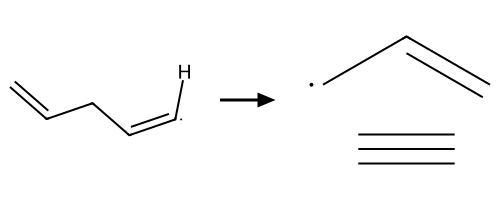

alt.LayerChart(...)

Median branching fraction: 1.0
[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]

(3, 2) C5H7(487)e = C2H2(40) + C3H5(122)


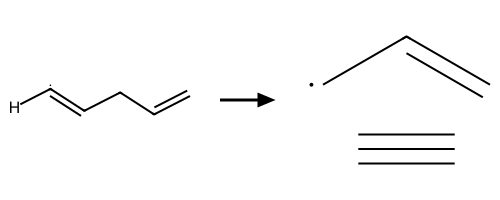

alt.LayerChart(...)

Median branching fraction: 0.0228898558668689
[[0.00039325 0.00160165 0.00230894 0.00243575]
 [0.00188542 0.00833407 0.01362569 0.01495879]
 [0.00644249 0.02777265 0.04901567 0.05647752]
 [0.01800706 0.06959791 0.12365657 0.1479463 ]
 [0.04665805 0.14281353 0.23752881 0.2865212 ]]

(4, 3) C5H7(504) = C5H7(487)e


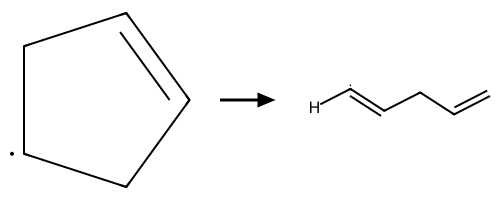

alt.LayerChart(...)

Median branching fraction: 0.0023339013243964916
[[0.00029205 0.00054324 0.00062624 0.00063844]
 [0.00065407 0.00160852 0.00217928 0.00228551]
 [0.00107064 0.00304006 0.004946   0.00557452]
 [0.00167489 0.00455291 0.00862669 0.01062363]
 [0.00238229 0.00593029 0.01220447 0.0168664 ]]

(5, 4) C5H7(500) = C5H7(504)


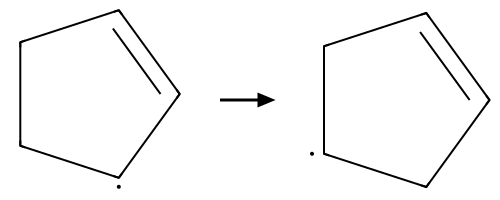

alt.LayerChart(...)

Median branching fraction: 0.14629948364888126
[[0.13996627 0.14355628 0.14495114        nan]
 [0.13257576 0.14629948 0.15030467 0.15065723]
 [0.12482066 0.14808462 0.1598916  0.16219119]
 [0.11511061 0.14576608 0.16848063 0.17569577]
 [0.1011236  0.1356674  0.17118644 0.18789809]]

(5, 6) C5H7(500) = C5H7(507)zz


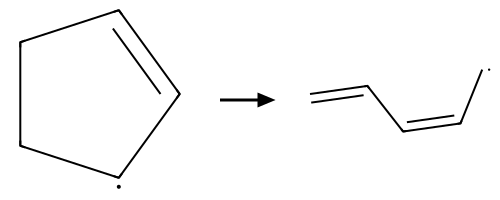

alt.LayerChart(...)

Median branching fraction: 0.8537005163511188
[[0.86003373 0.85644372 0.85504886        nan]
 [0.86742424 0.85370052 0.84969533 0.84934277]
 [0.87517934 0.85191538 0.8401084  0.83780881]
 [0.88488939 0.85423392 0.83151937 0.82430423]
 [0.8988764  0.8643326  0.82881356 0.81210191]]



In [112]:
label_dct = mess.surf.node_label_dict(surf_out)
obj_col = automech.util.df_.c_.temp()

print("Direct rates:")
for rate_key in mess.surf.rate_keys(
    surf_out, P_vals=[1.0], empty=False, well_skipping=False
):
    eq = mess.surf.edge_chemkin_equation(surf_out, rate_key)
    print(rate_key, eq)

    rate = surf_out.rates[rate_key]
    rate_fit = surf_out.rate_fits[rate_key]

    amchis = list(mit.unique_everseen(automech.reaction_amchis(mech, eq=eq)))
    for amchi in amchis:
        automol.amchi.display_reaction(*amchi)

    ref_rates = ref_labels = []
    if compare and amchis:
        ref_rates = [r.rate for r in automech.reaction_rate_objects(mech, eq)]
        ref_labels = [f"Ref {i}" for i, _ in enumerate(ref_rates)]

    display(
        ac.rate.data.display(
            [rate, rate_fit, *ref_rates],
            T_range=T_range,
            label=["Data", "Fit", *ref_labels],
            check_order=False,
        )
    )

    branch_frac_arr = branch_frac_dct[rate_key]
    branch_frac = np.nanmedian(branch_frac_arr)
    print(f"Median branching fraction: {branch_frac}")
    print(branch_frac_arr)
    print()

In [113]:
print("Well-skipping rates:")
for rate_key in mess.surf.rate_keys(surf_out, direct=False):
    print(rate_key)
    rate = surf_out.rates[rate_key]
    rate_fit = surf_out.rate_fits[rate_key]
    display(
        ac.rate.data.display([rate, rate_fit], T_range=T_range, label=["Data", "Fit"])
    )

    branch_frac_arr = branch_frac_dct[rate_key]
    branch_frac = np.nanmedian(branch_frac_arr)
    print(f"Median branching fraction: {branch_frac}")
    print(branch_frac_arr)
    print()

Well-skipping rates:
